In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.datasets import load_wine

from pprint import pprint as pprint
from copy import copy as copy

import sys
import os

sys.path.append(os.path.abspath(os.curdir) + "/")

from pca import PCA as pca_
from PCA_adaptative_P3 import PCA_adaptative as pca_adp_ 

import keras

from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [2]:
def fast_plot(relevance_values):
    cum_index_labels = relevance_values.index.tolist()

    plt.figure(figsize=(30, 15))
    plt.grid()
    
    x_ticks = len(relevance_values.index.tolist())

    to_plot= relevance_values.copy()
    to_plot.index = np.arange(x_ticks).tolist()

    plt.xticks(to_plot.index, cum_index_labels)

    plt.plot([10] * x_ticks, "k")
    plt.plot([20] * x_ticks, "k")
    plt.plot([50] * x_ticks, "k")
    plt.plot([75] * x_ticks, "k")

    plt.plot(to_plot, "*r")
    plt.plot(to_plot, "--g")
    
    plt.show()

In [3]:
def to_std_coord(data_frame):
    output = (data_frame - data_frame.min()) / (data_frame.max() - data_frame.min())
    output = (output - output.mean()) / output.std()
    return output

In [4]:
def pca_importance(eig_vals_column):
    repr_percnt = (eig_vals_column / eig_vals_column.sum()) * 100.0
    repr_percnt.sort_values(ascending=True,inplace=True)
     
    return pd.DataFrame(repr_percnt)

In [5]:
def relevance_print(__relevance):
    temp = __relevance.sort_values(by=__relevance.columns.tolist()[0],ascending=False).copy()
    temp.columns = ["Relevance %"]
    print(temp)
    del temp
    return None

In [6]:
def pca_transformer(data_frame, function, verbose=False):
    _, [eig_vals, eig_vect, _] = function(np.matrix(data_frame.values.tolist()))
    
    pca_transform_ = pd.DataFrame(np.arange(data_frame.shape[1]), columns=["id_x"])
    pca_transform_["eig_vals"] = eig_vals.tolist()
    pca_transform_.index = data_frame.columns.tolist()
    
    ii_ = 0
    for column_id in data_frame.columns.tolist():
        pca_transform_[column_id] = eig_vect[:, ii_]
        ii_ += 1
    
    __relevance = pca_importance(pca_transform_.eig_vals)
    cumulative_importance = __relevance.cumsum()
    
    if verbose:
        relevance_print(__relevance)
    else:
        pass
    
    fast_plot(cumulative_importance)
    
    cut_point = int(input("\ta que porcentagem fazer o corte?\t\t>>:\t"))

    columns_to_use = cumulative_importance[cumulative_importance.values > cut_point].index.tolist()
    
    output_post_pca = pd.DataFrame(np.dot(data_frame.values, pca_transform_[columns_to_use].values),
                                   columns=columns_to_use)
    
    return to_std_coord(output_post_pca)

In [7]:
def load_wine():
    wine = pd.read_csv("wine.csv", index_col=0, header=0, sep="\t", encoding="utf-8")
    
    targets = wine.iloc[:,-3:].copy()
    wine = wine.iloc[:,:-3]
    
    return wine, targets

In [8]:
def createModel(input_shape, nClasses):
    model = Sequential()
    
    model.add(Dense(8, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(0.2))
    model.add(Dense(5, activation='hard_sigmoid'))
    model.add(Dropout(0.1))
    model.add(Dense(nClasses, activation='softmax'))
    
    return model

In [9]:
def compile_model__(input_shape, num_classes, verbose=False):
    model__ = createModel(input_shape, num_classes)
    model__.compile(optimizer='adadelta', loss='categorical_crossentropy', metrics=['accuracy'])
    
    if verbose:
        model__.summary()
    else:
        pass
    
    return model__

In [10]:
def sampler_idx(data_frame, sample_ratio=0.75):
    num_data = data_frame.shape[0]

    index_list = np.arange(num_data, dtype=int)
    np.random.shuffle(index_list)

    train__ = index_list[:int(num_data * sample_ratio)]
    test___ = index_list[int(num_data * sample_ratio):]

    return train__, test___

In [11]:
def train_mlp(x_train, y_train, x_test, y_test, model__, epochs=100, batch_size_ratio=0.01):
    batch_size = int((x_train.shape[0] + x_test.shape[0]) * batch_size_ratio)
    
    history = model__.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0, 
                       validation_data=(x_test, y_test))
    
    model__.evaluate(x_test, y_test)

    return history

In [12]:
def plot_history(history_data):
    history = history_data
    
    plt.figure(figsize=[16,12])
    plt.subplot(2, 1, 1)

    # Loss Curves
    plt.plot(history.history['loss'],'.r')
    plt.plot(history.history['val_loss'],'.b')
    plt.plot(history.history['loss'],'--y')
    plt.plot(history.history['val_loss'],'--g')
    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    
    plt.subplot(2, 1, 2)
    
    # Accuracy Curves
    plt.plot(history.history['acc'],'.r')
    plt.plot(history.history['val_acc'],'.b')
    plt.plot(history.history['acc'],'--y')
    plt.plot(history.history['val_acc'],'--g')
    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)

    return plt

In [13]:
def main():
    wine, targets = load_wine()
    wine = to_std_coord(wine)
    
    train__, test___ = sampler_idx(wine)
    
    ###********###
    
    #### REGULAR WINE
    
    print("""
        xxxXXX WINE VANILLA XXXxx
    """)
    
    df_case = wine
    
    ### Paramethers

    input_shape = df_case.shape[1]
    num_classes = targets.shape[1]

    ####

    # The data, split between train and test sets:

    x_train = df_case.iloc[train__, :].values
    y_train = targets.iloc[train__, :].values

    x_test = df_case.iloc[test___, :].values
    y_test = targets.iloc[test___, :].values
    
    
    model__ = compile_model__(input_shape, num_classes)
    wine_history = train_mlp(x_train, y_train, x_test, y_test, model__)
    
    plot_history(wine_history).show()
    ###********###
    
    #### CLASSIC PCA WINE
    
    print("""
        xxxXXX CLASSIC PCA WINE XXXxx
    """)
    
    wine_pca_classic = pca_transformer(wine, pca_, verbose=True)
    
    df_case = wine_pca_classic
    
    ### Paramethers

    input_shape = df_case.shape[1]
    num_classes = targets.shape[1]

    ####

    # The data, split between train and test sets:

    x_train = df_case.iloc[train__, :].values
    y_train = targets.iloc[train__, :].values

    x_test = df_case.iloc[test___, :].values
    y_test = targets.iloc[test___, :].values
    
    
    model__ = compile_model__(input_shape, num_classes)
    classic_pca_history = train_mlp(x_train, y_train, x_test, y_test, model__)
    
    plot_history(classic_pca_history).show()
    ###********###
    
    #### ADAPATATIVE PCA WINE
        
    print("""
        xxxXXX ADAPTATIVE PCA WINE XXXxx
    """)
    
    wine_pca_adapatative = pca_transformer(wine, pca_adp_, verbose=True)
    
    df_case = wine_pca_adapatative
    
    ### Paramethers

    input_shape = df_case.shape[1]
    num_classes = targets.shape[1]

    ####

    # The data, split between train and test sets:

    x_train = df_case.iloc[train__, :].values
    y_train = targets.iloc[train__, :].values

    x_test = df_case.iloc[test___, :].values
    y_test = targets.iloc[test___, :].values
    
    
    model__ = compile_model__(input_shape, num_classes)
    adaptative_pca_history = train_mlp(x_train, y_train, x_test, y_test, model__)
    
    plot_history(adaptative_pca_history).show()
    ###********###
    
    return None


        xxxXXX WINE VANILLA XXXxx
    
45/45 [==============================] - 0s 125us/step


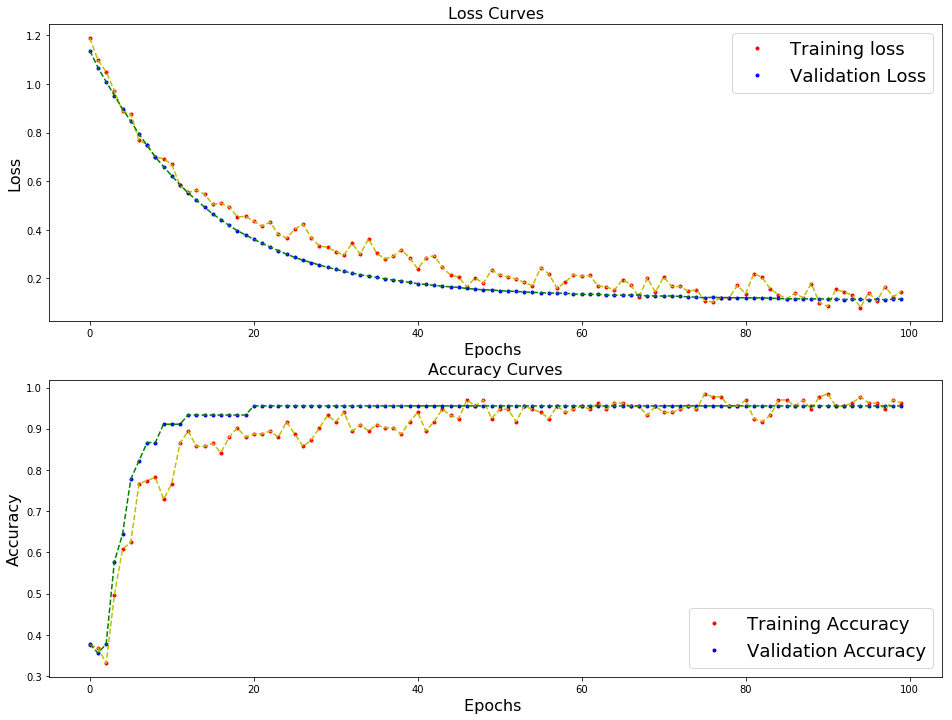


        xxxXXX CLASSIC PCA WINE XXXxx
    
                              Relevance %
alcohol                         36.198848
malic_acid                      19.207490
ash                             11.123631
alcalinity_of_ash                7.069030
magnesium                        6.563294
total_phenols                    4.935823
flavanoids                       4.238679
proanthocyanins                  2.680749
hue                              2.222153
proline                          1.930019
od280/od315_of_diluted_wines     1.736836
color_intensity                  1.298233
nonflavanoid_phenols             0.795215


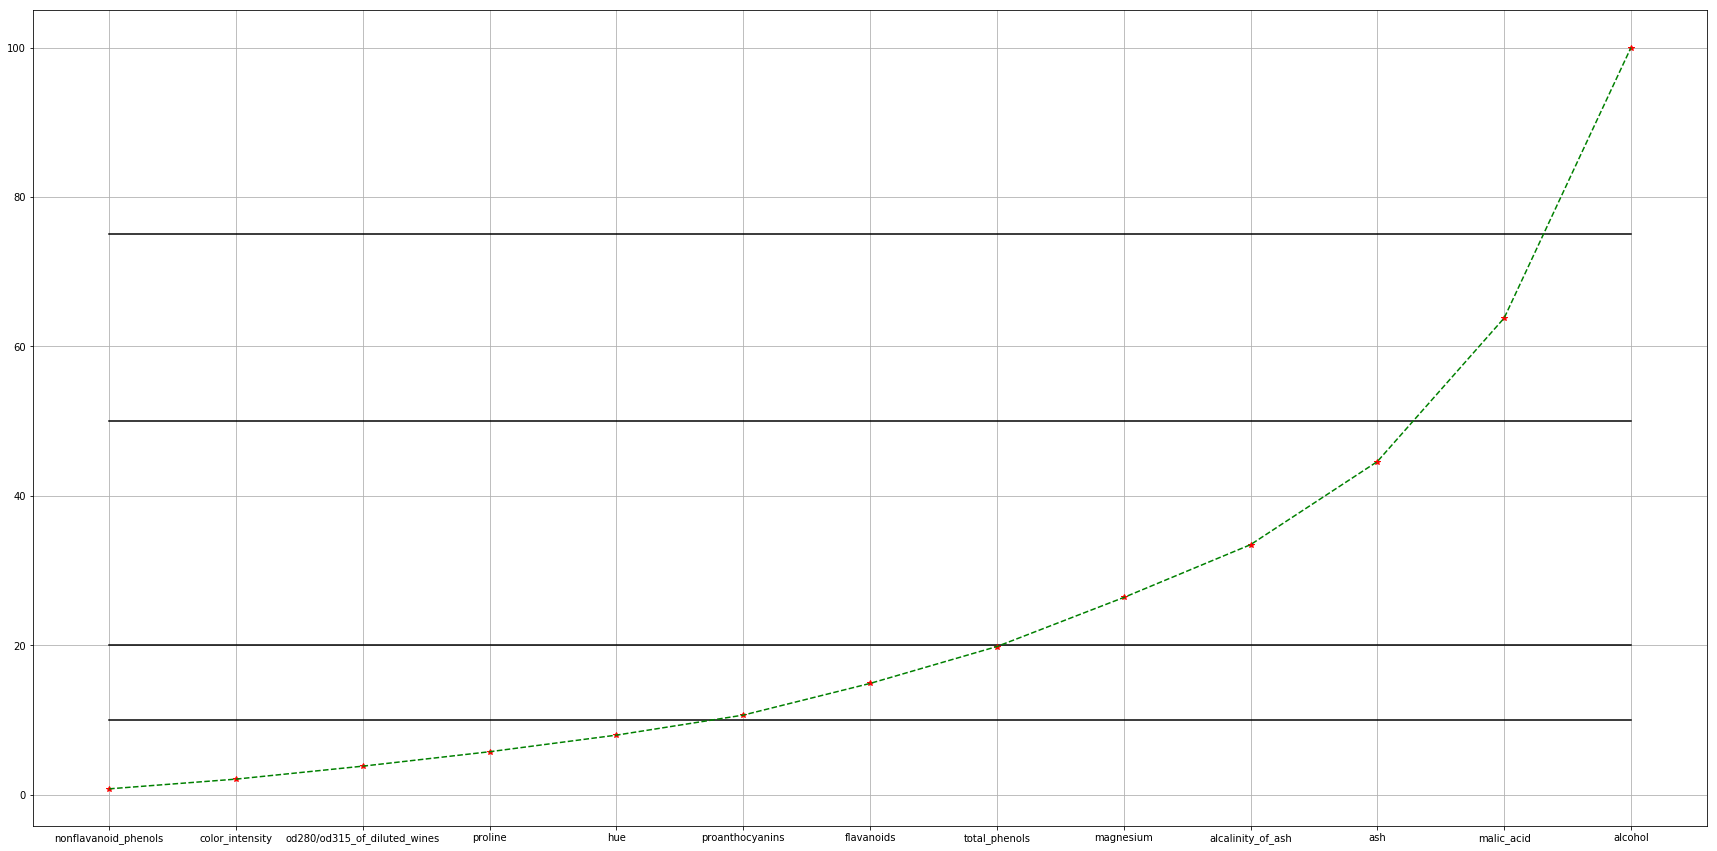

	a que porcentagem fazer o corte?		>>:	20
45/45 [==============================] - 0s 90us/step


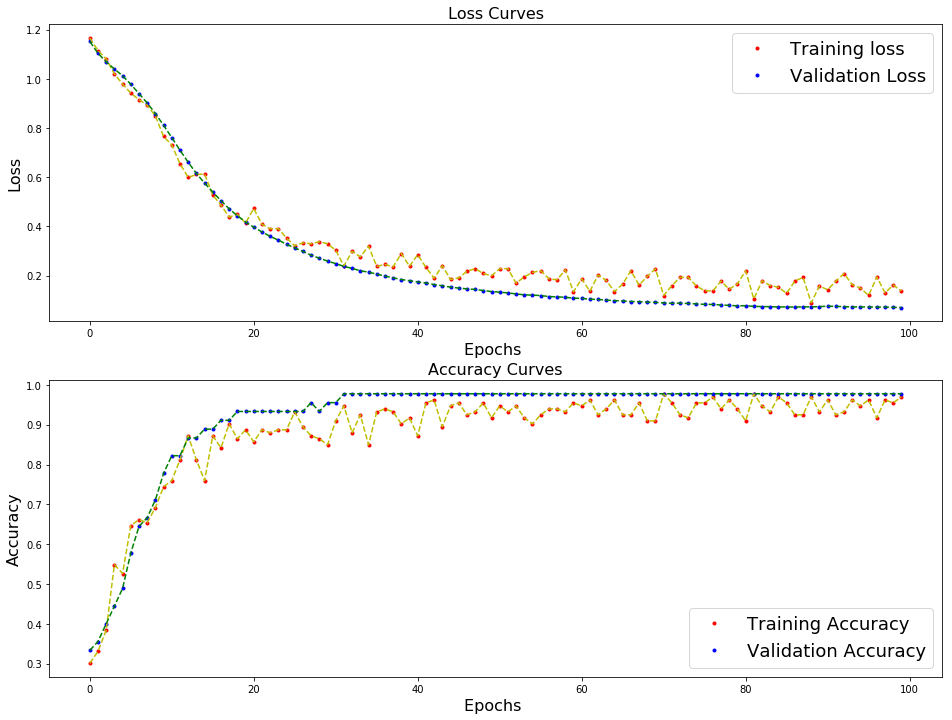


        xxxXXX ADAPTATIVE PCA WINE XXXxx
    
                              Relevance %
alcohol                         19.329810
malic_acid                      13.986309
ash                             10.735028
alcalinity_of_ash                8.558073
magnesium                        8.251536
total_phenols                    7.156269
flavanoids                       6.636788
nonflavanoid_phenols             5.276198
proanthocyanins                  4.801283
color_intensity                  4.474312
hue                              4.247415
od280/od315_of_diluted_wines     3.672289
proline                          2.874692


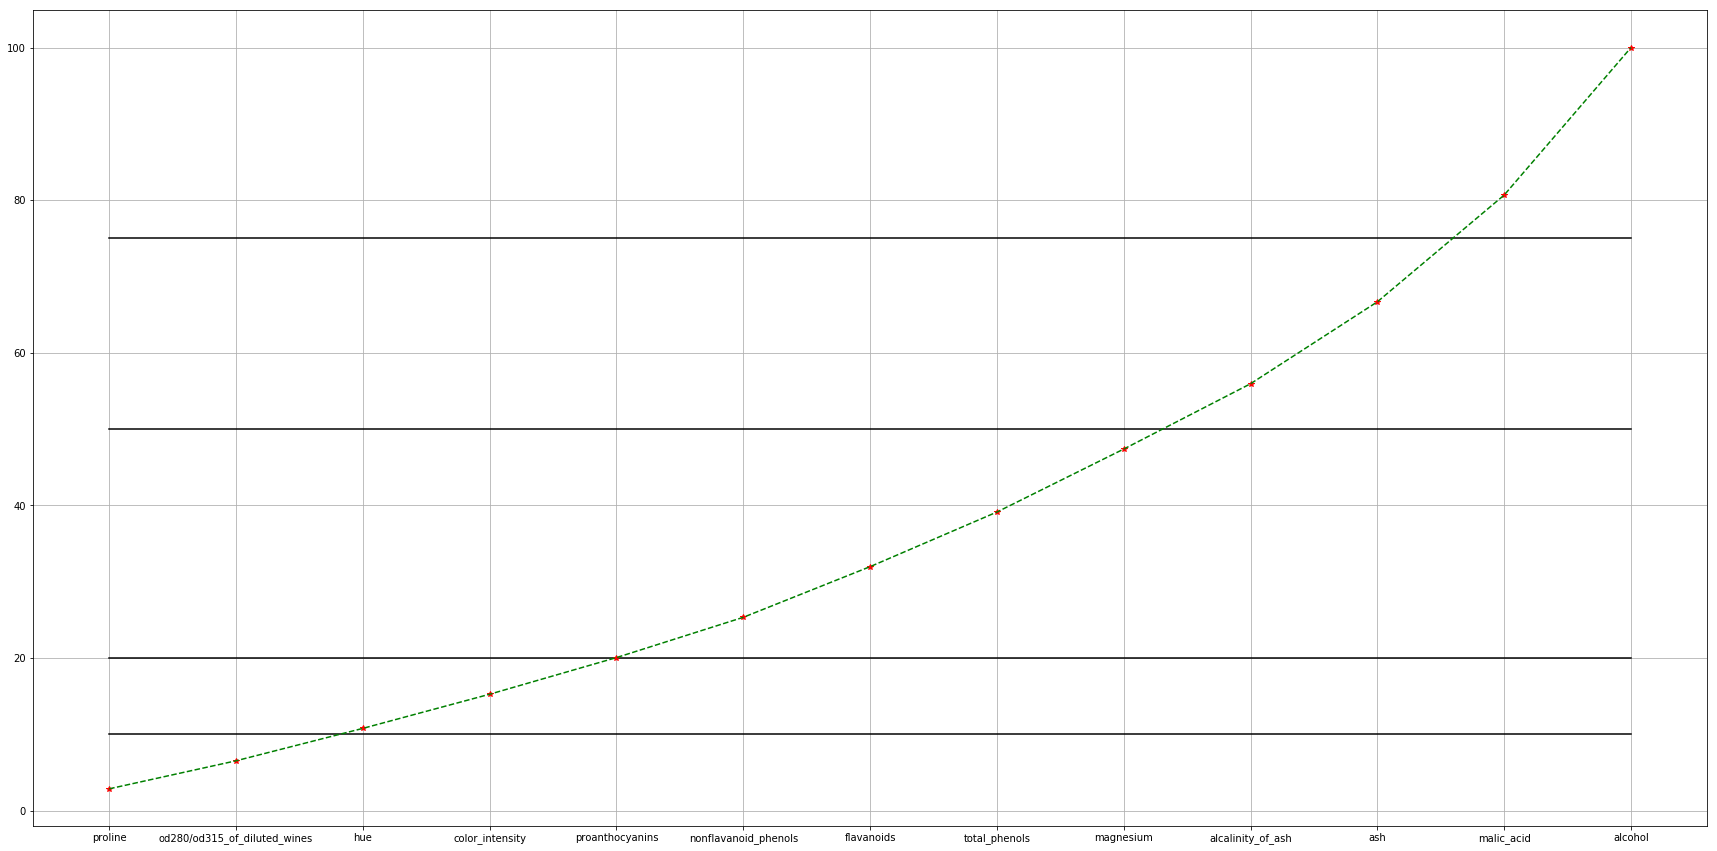

	a que porcentagem fazer o corte?		>>:	20
45/45 [==============================] - 0s 84us/step


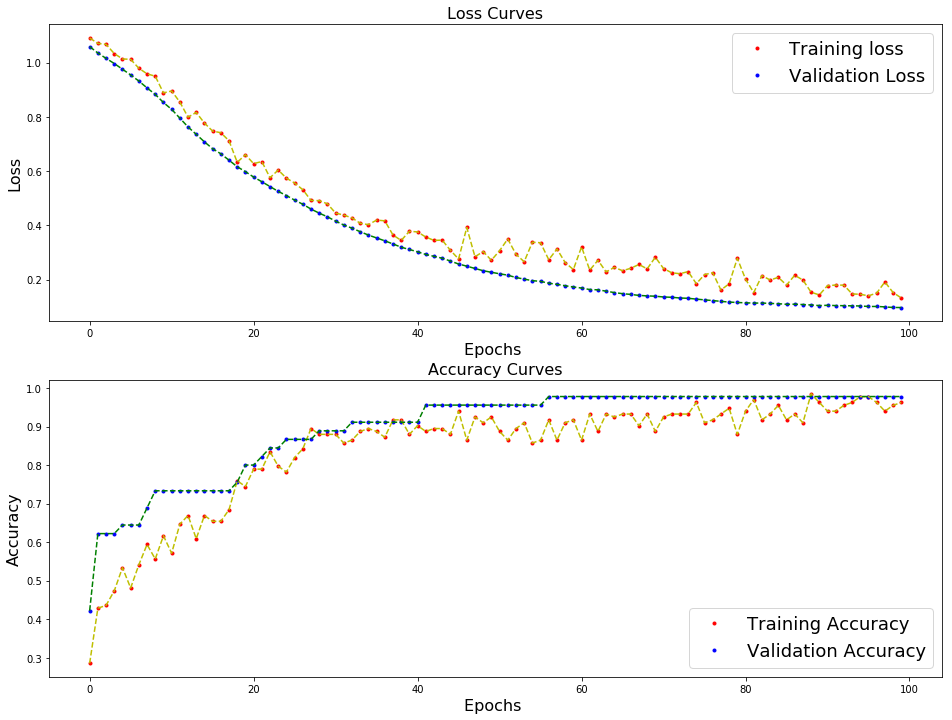

In [14]:
main()